# ECG time series clustering using Self organising maps and Dynamic Time Warping Barycenter Averaging 

In [1]:
# Native libraries
import os
import math
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# Algorithms
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

In [ ]:
df = pd.read_parquet('ecg_signals.parquet')

In [ ]:
min_len = df['ECG_Signal'].apply(len).min()

In [ ]:
ecg_signal_series = df['ECG_Signal']

In [ ]:
fig, axs = plt.subplots(6,4,figsize=(25,25))
fig.suptitle('Series')
for i in range(6):
    for j in range(4):
        axs[i, j].plot(ecg_signal_series.iloc[i*4+j][0:1000])
        #axs[i, j].set_title(namesofMySeries[i*4+j])
plt.show()

In [ ]:
scaler = MinMaxScaler()

In [ ]:
scaled_ecgs = []
for idx, value in ecg_signal_series.items():
    scaled_ecg = scaler.fit_transform(value.reshape(-1, 1))
    scaled_ecgs.append(scaled_ecg)

In [ ]:
# cut ecgs to min len (todo: rescale ecgs rather than cutoff)
cut_ecg = []
for value in scaled_ecgs:
    cut_ecg.append(value[:min_len])

In [ ]:
cut_ecg = np.array(cut_ecg)

In [ ]:
cut_ecg_reshaped = cut_ecg.reshape(cut_ecg.shape[0], -1)
cut_ecg_reshaped

In [12]:
math.ceil(math.sqrt(math.sqrt(len(heartbeats))))

18

In [10]:
def plot_som_series_dba_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="gray",alpha=0.5) 
                axs[cluster].plot(dtw_barycenter_averaging(np.vstack(win_map[cluster])),c="red") # I changed this part
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()

In [14]:
# Little handy function to plot series
def plot_som_series_averaged_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="gray",alpha=0.5) 
                axs[cluster].plot(np.average(np.vstack(win_map[cluster]),axis=0),c="red")
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()

In [13]:
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(heartbeats))))
# I didn't see its significance but to make the map square,
# I calculated square root of map size which is 
# the square root of the number of series
# for the row and column counts of som

som = MiniSom(10, 10, len(heartbeats[0]), sigma=0.3, learning_rate = 0.1)

som.random_weights_init(heartbeats)
som.train(heartbeats, 1000)

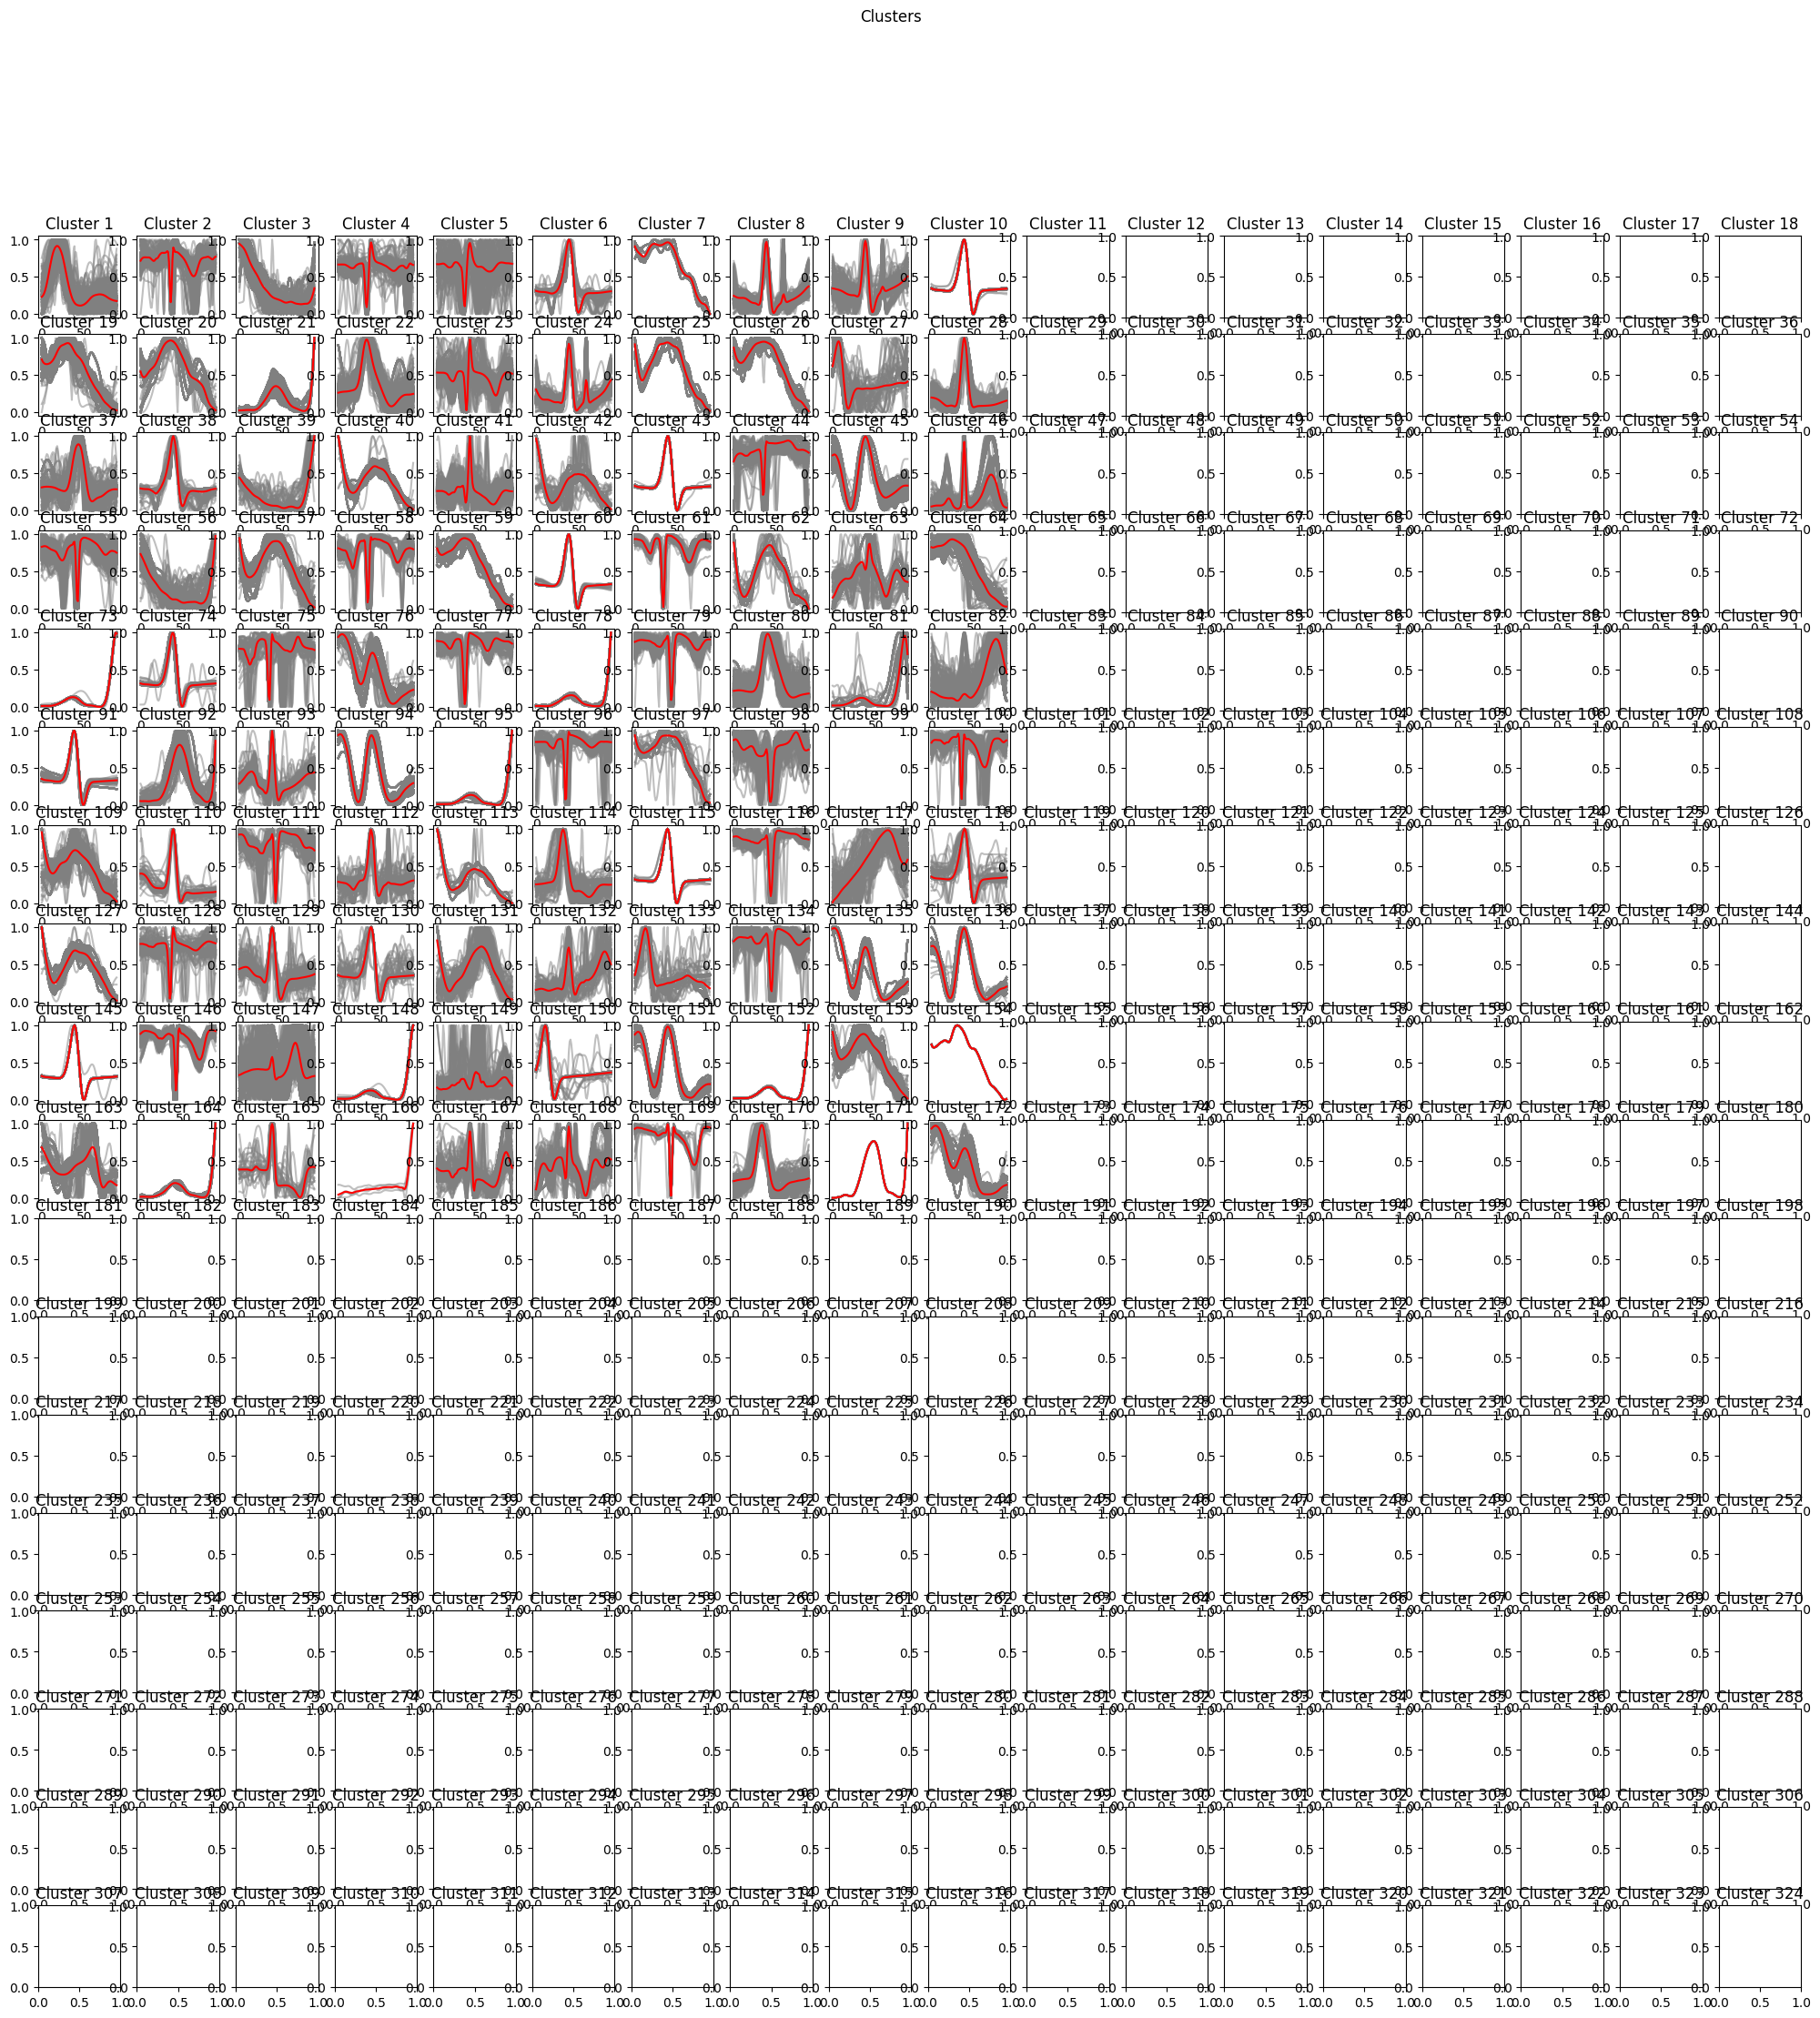

In [15]:
win_map = som.win_map(heartbeats)
# Returns the mapping of the winner nodes and inputs

plot_som_series_averaged_center(som_x, som_y, win_map)

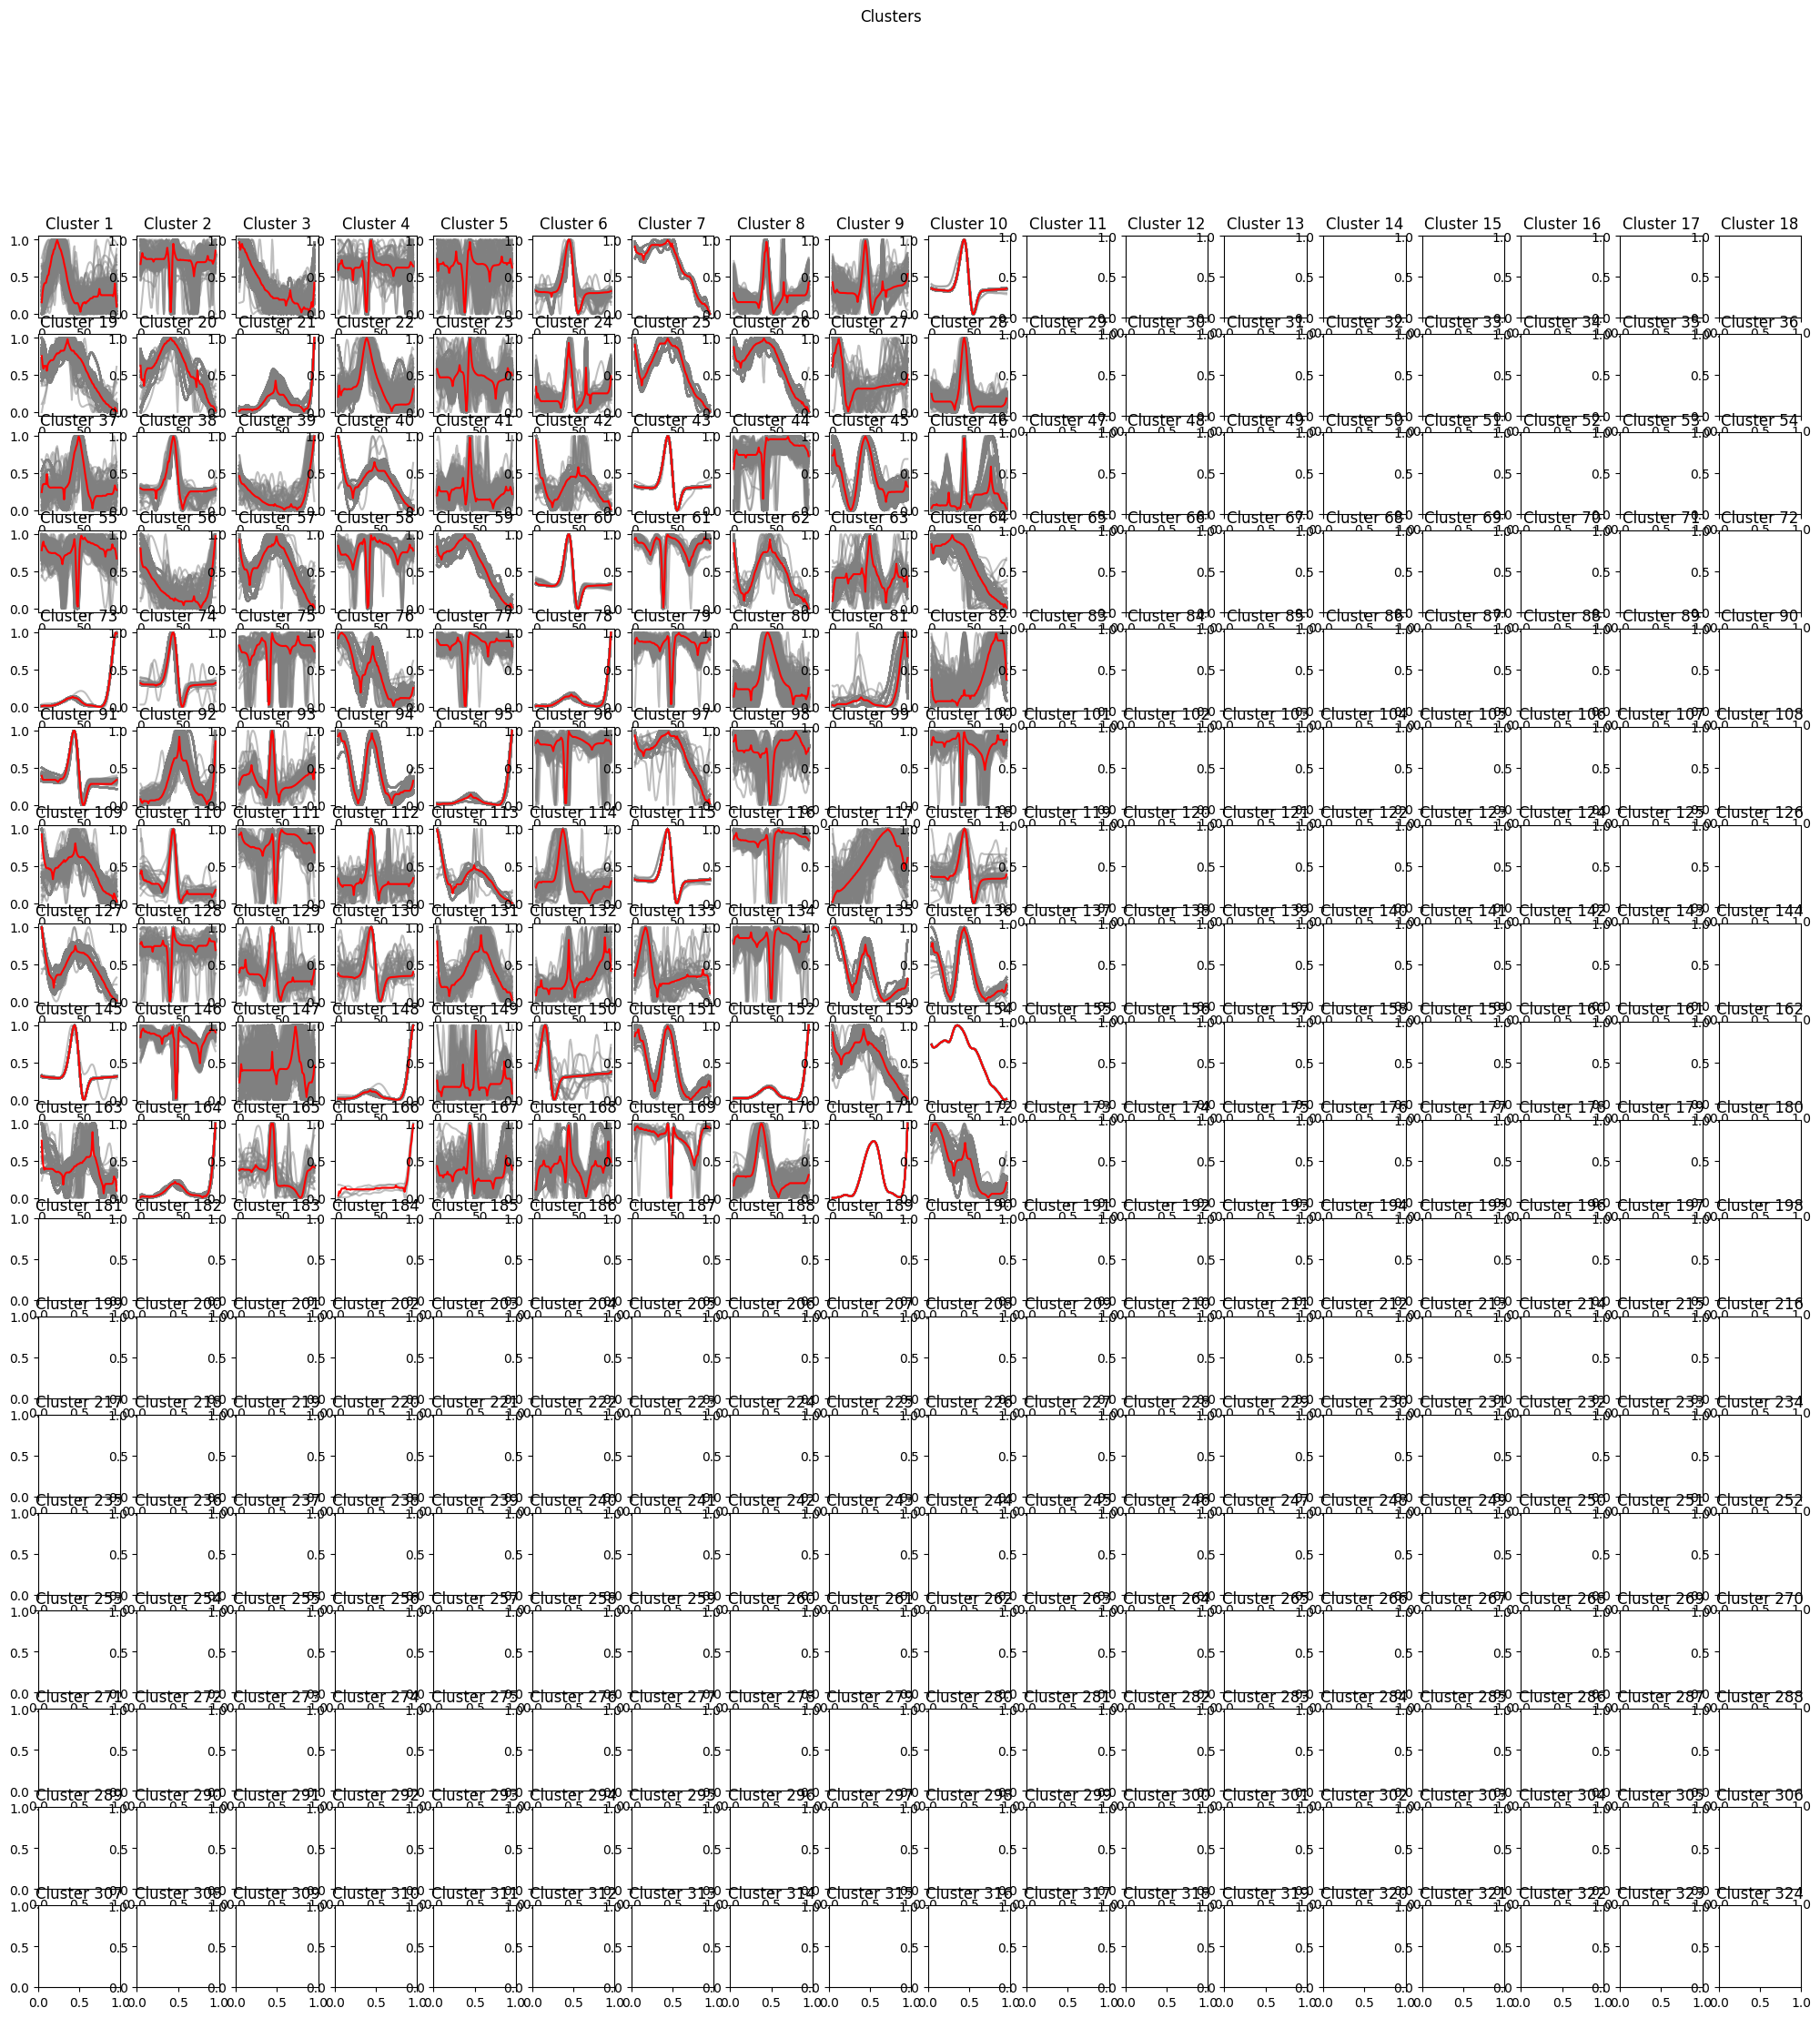

In [16]:
win_map = som.win_map(heartbeats)

plot_som_series_dba_center(som_x, som_y, win_map)

In [ ]:
# first identify separat heart beats and use them instead whole ecg signal
import neurokit2 as nk
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

import warnings
warnings.filterwarnings("ignore")

In [ ]:
database_to_frequency = {
    'BIDMC': 125,
    'Fantasia': 250,
    'Capnobase': 300
}

In [ ]:
# Define a function to create epochs
def extract_heartbeats(cleaned, peaks, sampling_rate=None): 
    heartbeats = nk.epochs_create(cleaned, 
                                  events=peaks, 
                                  epochs_start=-0.3, 
                                  epochs_end=0.4, 
                                  sampling_rate=sampling_rate)
    heartbeats = nk.epochs_to_df(heartbeats)
    return heartbeats

In [ ]:
ecg_signal = bidmc_df['ECG_Signal'].iloc[0]
hbs = []
signals, info = nk.ecg_process(ecg_signal, sampling_rate=125)
rpeaks = info["ECG_R_Peaks"]
cleaned_ecg = signals["ECG_Clean"]

heartbeats = extract_heartbeats(cleaned_ecg, peaks=rpeaks, sampling_rate=125)
heartbeats_pivoted = heartbeats.pivot(index='Time', columns='Label', values='Signal')

labels = list(heartbeats_pivoted)
for label in labels:
    hbs.append(heartbeats_pivoted[label].values.tolist())
    #bidmc_heartbeats.append(heartbeats_pivoted[label].values) 

In [ ]:
def ecg_to_heartbeats(row):
    ecg_signal = row['ECG_Signal']
    patient = row['Record']
    fs = database_to_frequency[row['Database']]
    bidmc_heartbeats = []
    try:
        signals, info = nk.ecg_process(ecg_signal, sampling_rate=fs)  
    except Exception as ex:
        signals, info = nk.ecg_process(ecg_signal, sampling_rate=fs, method='pantompkins1985')
    
    finally:   
        rpeaks = info["ECG_R_Peaks"]
        cleaned_ecg = signals["ECG_Clean"]

        heartbeats = extract_heartbeats(cleaned_ecg, peaks=rpeaks, sampling_rate=125)
        heartbeats_pivoted = heartbeats.pivot(index='Time', columns='Label', values='Signal')

        labels = list(heartbeats_pivoted)
        for label in labels:
            bidmc_heartbeats.append(heartbeats_pivoted[label].values.tolist())
    return bidmc_heartbeats

In [ ]:
bidmc_df = pd.read_parquet('bidmc_data.parquet')

In [ ]:
bidmc_df['heartbeats'] = bidmc_df.apply(ecg_to_heartbeats, axis=1)

In [ ]:
fantasia_df = pd.read_parquet('fantasia_data.parquet')
fantasia_df['heartbeats'] = fantasia_df.apply(ecg_to_heartbeats, axis=1)

In [ ]:
capnobase_df = pd.read_parquet('capnobase_data.parquet')
capnobase_df['heartbeats'] = capnobase_df.apply(ecg_to_heartbeats, axis=1)

In [ ]:
len(capnobase_df['heartbeats'].iloc[0])

In [ ]:
capnobase_df.shape

In [ ]:
232 * 38

In [ ]:
df = pd.concat([bidmc_df['heartbeats'].explode('heartbeats'), fantasia_df['heartbeats'].explode('heartbeats'), capnobase_df['heartbeats'].explode('heartbeats')]).to_frame('heartbeats')

In [ ]:
df

In [ ]:
df.to_parquet('heartbeats.parquet')

In [2]:
df = pd.read_parquet('heartbeats.parquet')

In [3]:
df.reset_index(inplace=True)

In [4]:
df.drop(columns=['index'], inplace=True)

In [5]:
df['heartbeats_scaled'] = df['heartbeats'].apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))

In [ ]:
df

In [6]:
heartbeats = df['heartbeats_scaled'].tolist()

In [ ]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

In [ ]:
# File to store pairwise distances incrementally
distances_file = "pairwise_distances.txt"

num_heartbeats = len(heartbeats)
dtw_matrix = np.zeros((num_heartbeats, num_heartbeats))

# Compute the DTW distances and write to file
with open(distances_file, 'w') as f:
    for i in range(num_heartbeats):
        for j in range(i+1, num_heartbeats):
            distance, _ = fastdtw([heartbeats[i]], [heartbeats[j]], dist=euclidean)
            # Write the distances in the format: i,j,distance
            f.write(f"{i},{j},{distance}\n")

# To populate the matrix from the file:
dtw_matrix = np.zeros((num_heartbeats, num_heartbeats))
with open(distances_file, 'r') as f:
    for line in f:
        i, j, distance = map(float, line.strip().split(","))
        i, j = int(i), int(j)
        dtw_matrix[i, j] = distance
        dtw_matrix[j, i] = distance  # since the matrix is symmetric

In [ ]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
# Initialize an empty matrix for DTW distances
num_heartbeats = len(heartbeats)
dtw_matrix = np.zeros((num_heartbeats, num_heartbeats))

# Compute the DTW distances
for i in range(num_heartbeats):
    for j in range(i+1, num_heartbeats):
        distance, _ = fastdtw([heartbeats[i]], [heartbeats[j]], dist=euclidean)
        dtw_matrix[i, j] = distance
        dtw_matrix[j, i] = distance  # since the matrix is symmetric

In [ ]:
from joblib import Parallel, delayed

def compute_dtw(i, heartbeats):
    distances = []
    for j in range(i+1, len(heartbeats)):
        distance, _ = fastdtw([heartbeats[i]], [heartbeats[j]], dist=euclidean)
        distances.append((i, j, distance))
    return distances

num_heartbeats = len(heartbeats)
dtw_matrix = np.zeros((num_heartbeats, num_heartbeats))

# Compute the DTW distances in parallel using joblib
results = Parallel(n_jobs=-1)(delayed(compute_dtw)(i, heartbeats) for i in range(num_heartbeats))

# Fill the dtw_matrix with computed distances
for distances in results:
    for i, j, distance in distances:
        dtw_matrix[i, j] = distance
        dtw_matrix[j, i] = distance  # since the matrix is symmetric


In [ ]:
# File to store pairwise distances incrementally
distances_file = "pairwise_distances.txt"

# Compute the DTW distances and write to file
with open(distances_file, 'w') as f:
    for i in range(num_heartbeats):
        for j in range(i+1, num_heartbeats):
            distance, _ = fastdtw(heartbeats[i], heartbeats[j], dist=euclidean)
            # Write the distances in the format: i,j,distance
            f.write(f"{i},{j},{distance}\n")

# To populate the matrix from the file:
dtw_matrix = np.zeros((num_heartbeats, num_heartbeats))
with open(distances_file, 'r') as f:
    for line in f:
        i, j, distance = map(float, line.strip().split(","))
        i, j = int(i), int(j)
        dtw_matrix[i, j] = distance
        dtw_matrix[j, i] = distance  # since the matrix is symmetric